In [1]:
# Import base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt
import warnings

# Module 1-Data Cleaning and EDA

In [9]:
# Set plot style and parameters
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

print("--- 1. Load Data ---")
# Load the dataset. This dataset typically requires a specific encoding.
try:
    df = pd.read_csv('/Users/HP/Desktop/Online Retail.csv')
except FileNotFoundError:
    print("Error: 'Online_Retail.csv' not found. Please download it from the UCI repository.")
    # exit() 

print("Original data shape:", df.shape)
print(df.head())

--- 1. Load Data ---
Original data shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  2010/12/1 8:26       2.55     17850.0  United Kingdom  
1  2010/12/1 8:26       3.39     17850.0  United Kingdom  
2  2010/12/1 8:26       2.75     17850.0  United Kingdom  
3  2010/12/1 8:26       3.39     17850.0  United Kingdom  
4  2010/12/1 8:26       3.39     17850.0  United Kingdom  


In [10]:
print("\n--- 2. Data Cleaning ---")

# 2.1 Check and handle missing values
print("\nMissing value statistics:")
print(df.isnull().sum())

# CustomerID has many missing values but is crucial for segmentation. We must drop these rows.
df_cleaned = df.dropna(subset=['CustomerID'])
print(f"\nShape after dropping missing CustomerID: {df_cleaned.shape}")


--- 2. Data Cleaning ---

Missing value statistics:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Shape after dropping missing CustomerID: (406829, 8)


In [15]:
# 2.2 Convert data types
# Convert InvoiceDate to datetime objects for time-based analysis
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [16]:
# 2.3 Handle anomalies (return orders)
# In this dataset, Quantity < 0 and InvoiceNo starting with 'C' indicate returns.
# We should exclude these when analyzing sales.
print(f"\nTotal records before cleaning: {df_cleaned.shape[0]}")
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0] # Also exclude items with zero price
print(f"Total records after cleaning: {df_cleaned.shape[0]}")


Total records before cleaning: 392692
Total records after cleaning: 392692


In [17]:
# 2.4 Drop duplicate rows
print(f"\nNumber of duplicate rows: {df_cleaned.duplicated().sum()}")
df_cleaned = df_cleaned.drop_duplicates()
print(f"Shape after dropping duplicates: {df_cleaned.shape}")


Number of duplicate rows: 0
Shape after dropping duplicates: (392692, 9)


In [18]:
print("\n--- 3. Feature Engineering ---")
# Create a new feature: TotalPrice
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
print(df_cleaned[['Quantity', 'UnitPrice', 'TotalPrice']].head())


--- 3. Feature Engineering ---
   Quantity  UnitPrice  TotalPrice
0         6       2.55       15.30
1         6       3.39       20.34
2         8       2.75       22.00
3         6       3.39       20.34
4         6       3.39       20.34



--- 4. Exploratory Data Analysis (EDA) ---


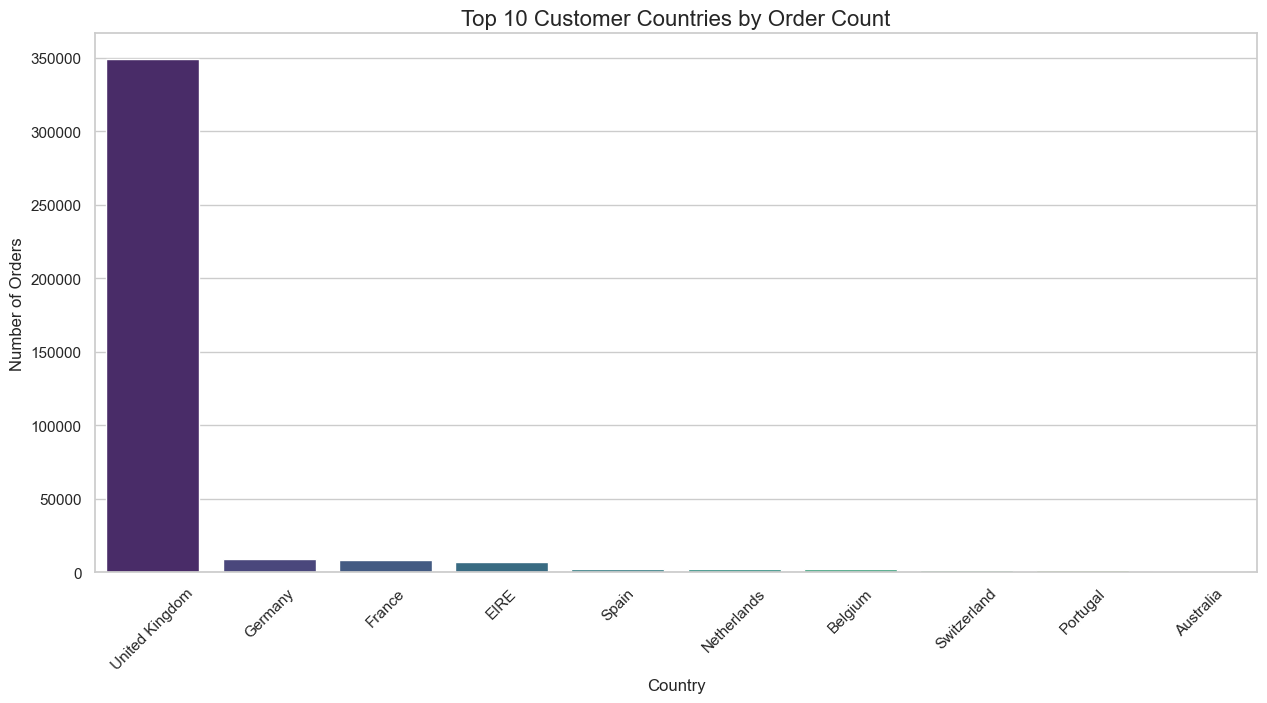

Insight: The vast majority of orders are from the United Kingdom. Future analysis could focus on the UK market.


In [19]:
print("\n--- 4. Exploratory Data Analysis (EDA) ---")

# 4.1 Customer's Geographic Distribution
plt.figure(figsize=(15, 7))
country_counts = df_cleaned['Country'].value_counts().head(10)
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.title('Top 10 Customer Countries by Order Count', fontsize=16)
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()
print("Insight: The vast majority of orders are from the United Kingdom. Future analysis could focus on the UK market.")

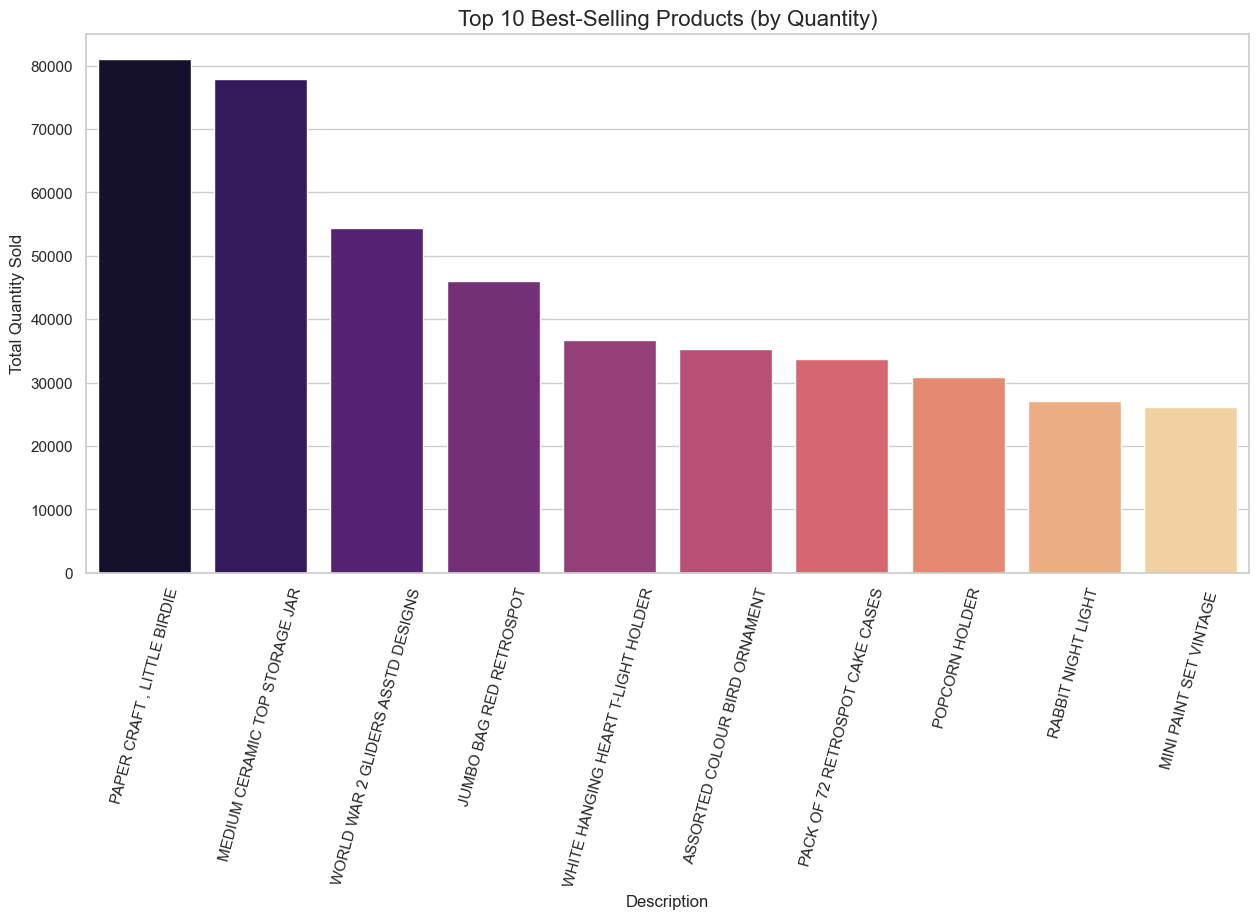

In [20]:
# 4.2 Top 10 Best-Selling Products
plt.figure(figsize=(15, 7))
top_products = df_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.index, y=top_products.values, palette='magma')
plt.title('Top 10 Best-Selling Products (by Quantity)', fontsize=16)
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=75)
plt.show()
# We will select one of these best-sellers for forecasting in Module 3.

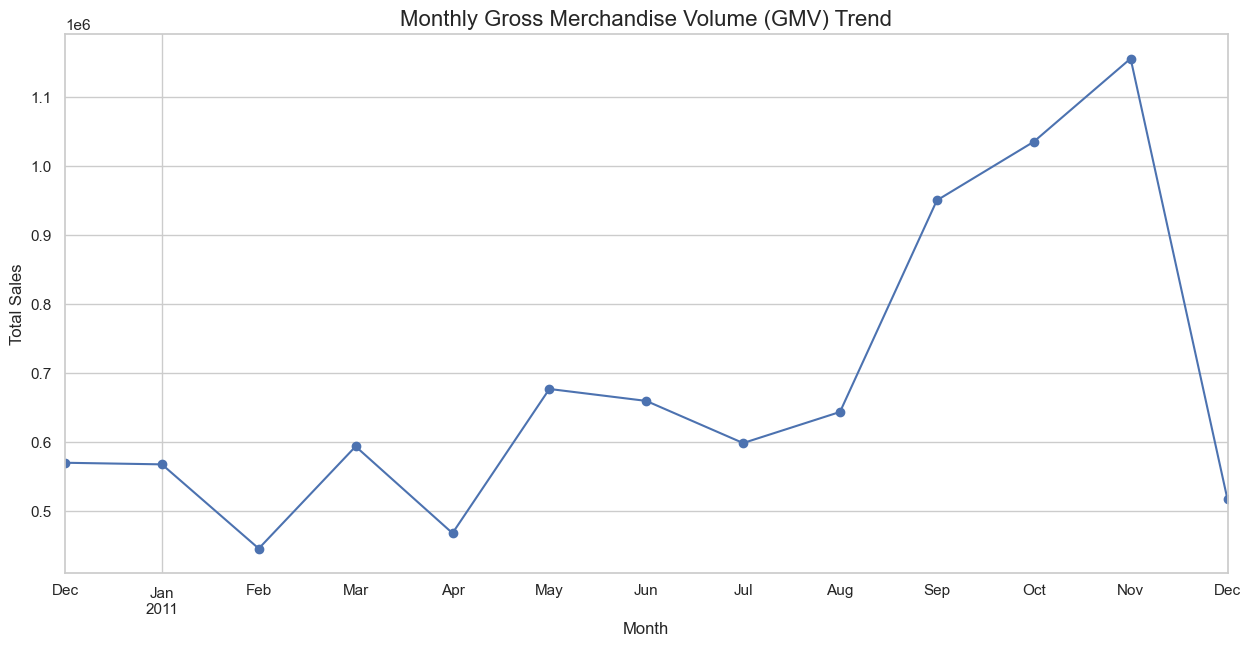

Insight: Sales peak significantly at the end of the year (Oct-Nov), indicating strong seasonality, which is critical for forecasting.


In [21]:
# 4.3 Monthly Sales Trend (GMV)
# Resample data by month
df_monthly_sales = df_cleaned.set_index('InvoiceDate')['TotalPrice'].resample('M').sum()

plt.figure(figsize=(15, 7))
df_monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Gross Merchandise Volume (GMV) Trend', fontsize=16)
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.grid(True)
plt.show()
print("Insight: Sales peak significantly at the end of the year (Oct-Nov), indicating strong seasonality, which is critical for forecasting.")

In [22]:
# 4.4 Save cleaned data for the next modules
df_cleaned.to_csv('cleaned_online_retail.csv', index=False)
print("\n--- Data cleaning and EDA complete. Saved to 'cleaned_online_retail.csv' ---")


--- Data cleaning and EDA complete. Saved to 'cleaned_online_retail.csv' ---


Module 2-Customer Segmentation

In [23]:
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

print("--- 1. Load Cleaned Data ---")
try:
    # This reads the file saved from the cell above
    df = pd.read_csv('cleaned_online_retail.csv')
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
except FileNotFoundError:
    print("Error: 'cleaned_online_retail.csv' not found. Please run the Cell 1 first.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

print(df.head())

--- 1. Load Cleaned Data ---
   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  


In [25]:
print("\n--- 2. RFM Feature Engineering ---")
# RFM (Recency, Frequency, Monetary) Model

# 2.1 Define a "snapshot" date, which is one day after the last transaction
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Snapshot date for analysis: {snapshot_date}")


--- 2. RFM Feature Engineering ---
Snapshot date for analysis: 2011-12-10 12:50:00


In [26]:
# 2.2 Calculate R, F, and M
rfm_data = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days), # R: Days since last purchase
    Frequency=('InvoiceNo', 'nunique'),                             # F: Total number of transactions
    Monetary=('TotalPrice', 'sum')                                  # M: Total monetary value
).reset_index()

print("\nRaw RFM Data:")
print(rfm_data.head())
print(rfm_data.describe())


Raw RFM Data:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     306.482500
50%    15299.500000    51.000000     2.000000     668.570000
75%    16778.750000   142.000000     5.000000    1660.597500
max    18287.000000   374.000000   209.000000  280206.020000



--- 3. RFM Data Preprocessing ---


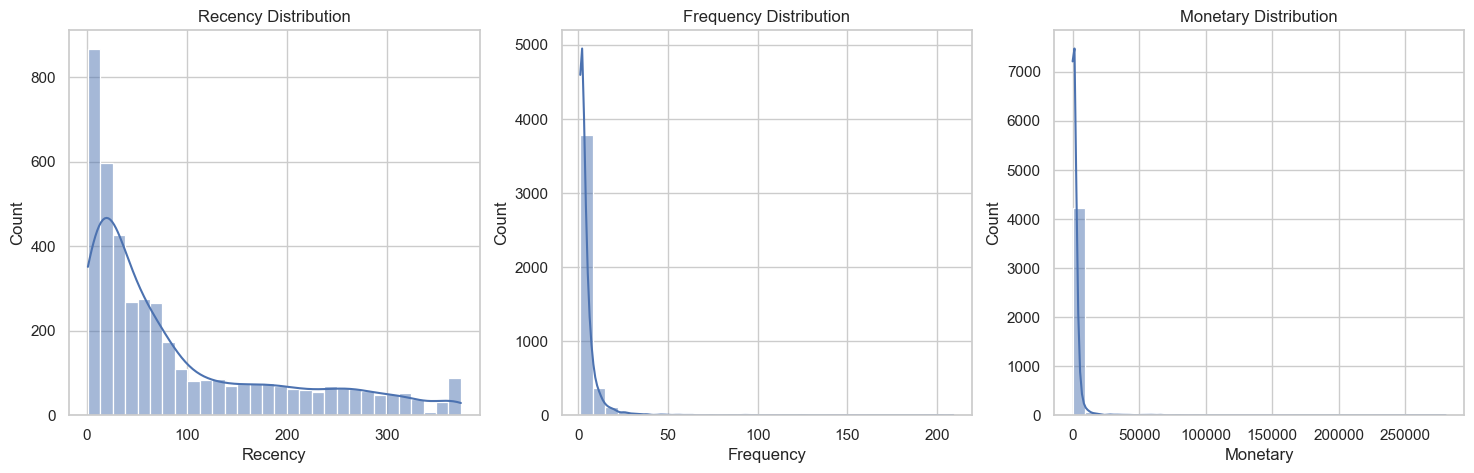

Insight: R, F, and M are all right-skewed (long-tail). Log transformation is needed.


In [27]:
print("\n--- 3. RFM Data Preprocessing ---")
# 3.1 Check and plot data distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm_data['Recency'], bins=30, kde=True, ax=axes[0]).set_title('Recency Distribution')
sns.histplot(rfm_data['Frequency'], bins=30, kde=True, ax=axes[1]).set_title('Frequency Distribution')
sns.histplot(rfm_data['Monetary'], bins=30, kde=True, ax=axes[2]).set_title('Monetary Distribution')
plt.show()
print("Insight: R, F, and M are all right-skewed (long-tail). Log transformation is needed.")

In [28]:
# 3.2 Log Transform
# Use np.log1p() to handle potential zero values (log(0) is undefined)
rfm_log = rfm_data.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

In [29]:
# 3.3 Data Scaling
# Clustering algorithms are sensitive to feature scales, so standardization is crucial
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("\nScaled RFM Data:")
print(rfm_scaled_df.head())


Scaled RFM Data:
    Recency  Frequency  Monetary
0  1.461993  -0.955214  3.707716
1 -2.038734   1.074425  1.414903
2  0.373104   0.386304  0.720024
3 -0.623086  -0.955214  0.702287
4  1.424558  -0.955214 -0.614514



--- 4. K-Means Clustering ---


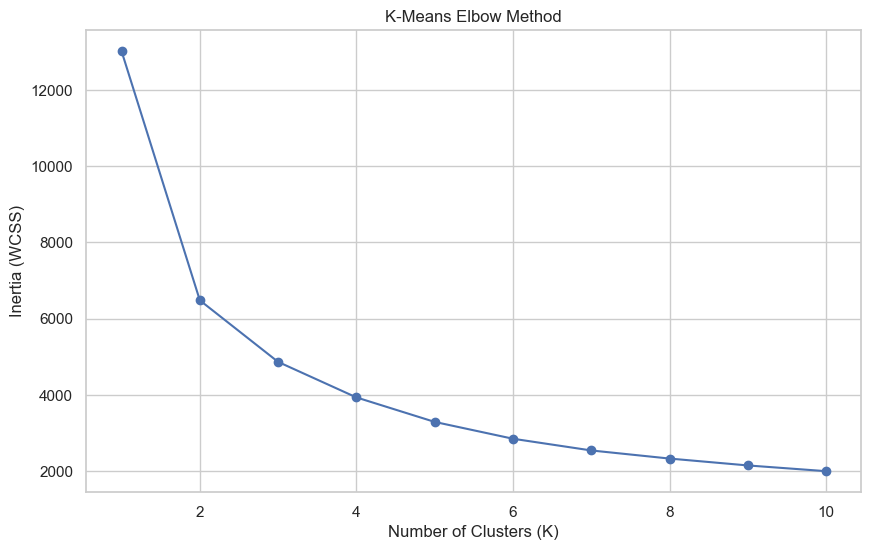

Insight: K=4 appears to be a good 'elbow' point.


In [30]:
print("\n--- 4. K-Means Clustering ---")
# 4.1 Use the "Elbow Method" to find the optimal K value
inertia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia[k] = kmeans.inertia_ # Inertia = Within-Cluster Sum of Squares (WCSS)

plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), 'o-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('K-Means Elbow Method')
plt.show()
print("Insight: K=4 appears to be a good 'elbow' point.")

In [31]:
# 4.2 Train K-Means Model (K=4)
k = 4
kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
clusters = kmeans_model.fit_predict(rfm_scaled_df)

# Add cluster labels back to the original RFM data
rfm_data['Cluster'] = clusters
print("\nRFM Data with Cluster Labels:")
print(rfm_data.head())


RFM Data with Cluster Labels:
   CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      326          1  77183.60        3
1     12347.0        2          7   4310.00        0
2     12348.0       75          4   1797.24        3
3     12349.0       19          1   1757.55        2
4     12350.0      310          1    334.40        1


In [32]:
print("\n--- 5. Customer Segmentation Analysis & Business Insights ---")
# 5.1 Analyze the RFM means for each cluster
cluster_analysis = rfm_data.groupby('Cluster').agg(
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("\nRFM Mean Values per Cluster:")
print(cluster_analysis)


--- 5. Customer Segmentation Analysis & Business Insights ---

RFM Mean Values per Cluster:
   Cluster  Recency_Mean  Frequency_Mean  Monetary_Mean  Count
0        0     12.171108       13.751753    8088.018331    713
1        1    181.506782        1.316893     340.998626   1622
2        2     17.698925        2.192354     557.322616    837
3        3     71.635506        4.078902    1801.777893   1166


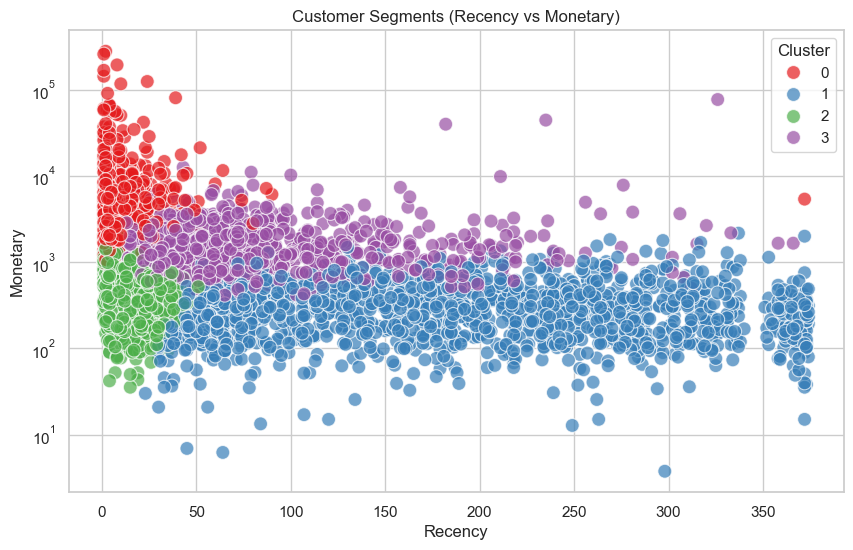

In [33]:
# 5.2 Visualize the clusters
# We'll use R and M for a 2D plot (F is often correlated with M)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm_data,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='Set1',
    s=100,
    alpha=0.7
)
plt.title('Customer Segments (Recency vs Monetary)')
plt.yscale('log') # Use log scale for Monetary due to high variance
plt.show()

In [34]:
# 5.3 Define Customer Personas & Strategies
print("\n--- Business Strategy Recommendations ---")
# Note: Cluster numbers (0, 1, 2, 3) are arbitrary. You must interpret them based on your 'cluster_analysis' output.
# The following is a typical interpretation:
print("\nCluster 0 (Example: Low R, High F, High M): **Champions**")
print("  - Profile: Purchased recently, buy often, and spend the most.")
print("  - Strategy: Reward them. Offer VIP services, loyalty programs, and early access to new products.")

print("\nCluster 1 (Example: High R, Low F, Low M): **At-Risk / Churned**")
print("  - Profile: Haven't purchased in a long time, low frequency and spend.")
print("  - Strategy: Win them back. Send personalized re-engagement emails, offer discounts, or survey them to find out why they left.")

print("\nCluster 2 (Example: Mid R, Mid F, Mid M): **Potential Loyalists**")
print("  - Profile: Average spenders who haven't shopped in a while.")
print("  - Strategy: Nurture them. Recommend related products (cross-sell), offer membership points, or time-sensitive promotions.")

print("\nCluster 3 (Example: Low R, Low F, Low M): **New Customers**")
print("  - Profile: Purchased very recently, but not often.")
print("  - Strategy: Onboard them. Provide a great first experience, send follow-up emails with tutorials, and encourage a second purchase.")


--- Business Strategy Recommendations ---

Cluster 0 (Example: Low R, High F, High M): **Champions**
  - Profile: Purchased recently, buy often, and spend the most.
  - Strategy: Reward them. Offer VIP services, loyalty programs, and early access to new products.

Cluster 1 (Example: High R, Low F, Low M): **At-Risk / Churned**
  - Profile: Haven't purchased in a long time, low frequency and spend.
  - Strategy: Win them back. Send personalized re-engagement emails, offer discounts, or survey them to find out why they left.

Cluster 2 (Example: Mid R, Mid F, Mid M): **Potential Loyalists**
  - Profile: Average spenders who haven't shopped in a while.
  - Strategy: Nurture them. Recommend related products (cross-sell), offer membership points, or time-sensitive promotions.

Cluster 3 (Example: Low R, Low F, Low M): **New Customers**
  - Profile: Purchased very recently, but not often.
  - Strategy: Onboard them. Provide a great first experience, send follow-up emails with tutorials, an

Module 3-Demand Forecasting & Inventory

In [41]:
!pip install prophet
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 58.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [42]:
print("--- 1. Load Cleaned Data ---")
try:
    # This also reads the file saved from Cell 1
    df = pd.read_csv('cleaned_online_retail.csv')
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
except FileNotFoundError:
    print("Error: 'cleaned_online_retail.csv' not found. Please run Cell 1 first.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

--- 1. Load Cleaned Data ---


--- 2. Prepare Time Series Data ---
SKU: 85123A has 2023 transaction records.

Data prepared for Prophet (first 5 rows):
          ds    y
0 2010-12-01  441
1 2010-12-02  309
2 2010-12-03   20
3 2010-12-04    0
4 2010-12-05  198


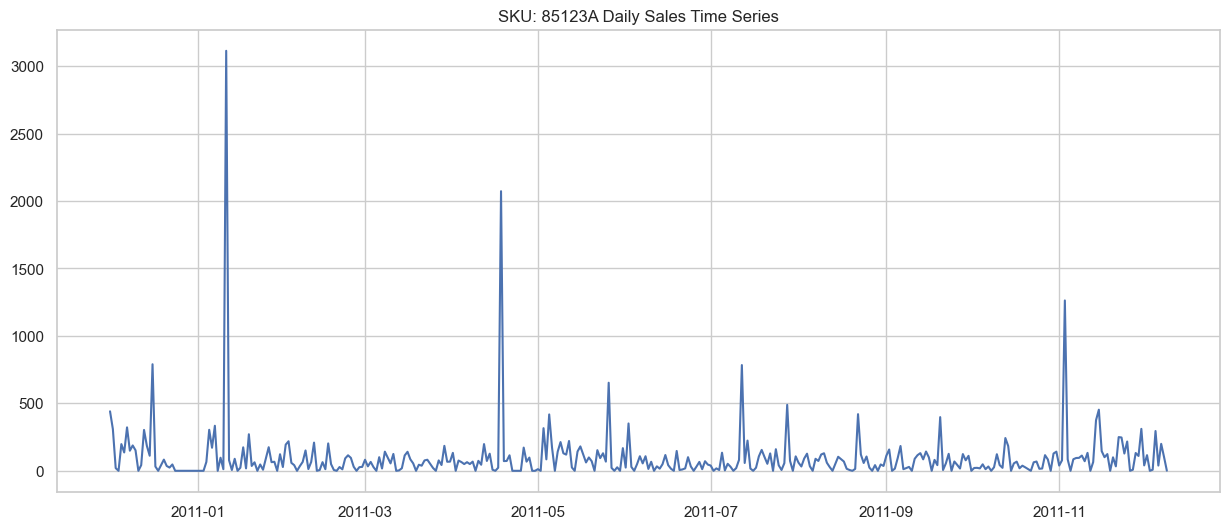

In [43]:
print("--- 2. Prepare Time Series Data ---")
# From our EDA in Notebook 01, we select a high-volume, consistent seller
# Example: '85123A' (WHITE HANGING HEART T-LIGHT HOLDER)
SKU_TO_FORECAST = '85123A' 

# Filter data for the specific SKU
sku_df = df[df['StockCode'] == SKU_TO_FORECAST].copy()
print(f"SKU: {SKU_TO_FORECAST} has {sku_df.shape[0]} transaction records.")

# Aggregate sales by day
sku_daily = sku_df.groupby(pd.Grouper(key='InvoiceDate', freq='D'))['Quantity'].sum().reset_index()

# Ensure all dates are present, filling missing dates with 0
# Prophet works best with a complete, continuous time series
sku_daily = sku_daily.set_index('InvoiceDate')
sku_daily = sku_daily.asfreq('D').fillna(0).reset_index()

# Rename columns to fit Prophet's requirements: 'ds' (datestamp) and 'y' (value)
sku_prophet = sku_daily.rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})

print("\nData prepared for Prophet (first 5 rows):")
print(sku_prophet.head())

plt.figure(figsize=(15, 6))
plt.plot(sku_prophet['ds'], sku_prophet['y'])
plt.title(f'SKU: {SKU_TO_FORECAST} Daily Sales Time Series')
plt.show()

In [44]:
print("\n--- 3. Train Prophet Forecasting Model ---")
# Initialize the model
# We know the data has weekly and yearly seasonality
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1 # Increase flexibility to capture trend changes
)

# Train the model
model.fit(sku_prophet)

print("Model training complete.")


--- 3. Train Prophet Forecasting Model ---


13:40:44 - cmdstanpy - INFO - Chain [1] start processing
13:40:45 - cmdstanpy - INFO - Chain [1] done processing


Model training complete.



--- 4. Generate and Visualize Forecast ---
Forecast results (last 5 rows):
            ds        yhat  yhat_lower  yhat_upper
399 2012-01-04   40.229708 -213.712814  301.596279
400 2012-01-05  102.904773 -174.759912  374.530500
401 2012-01-06   34.786282 -231.705646  290.890565
402 2012-01-07  -25.286158 -292.161922  239.278490
403 2012-01-08   44.371133 -223.919221  306.521732


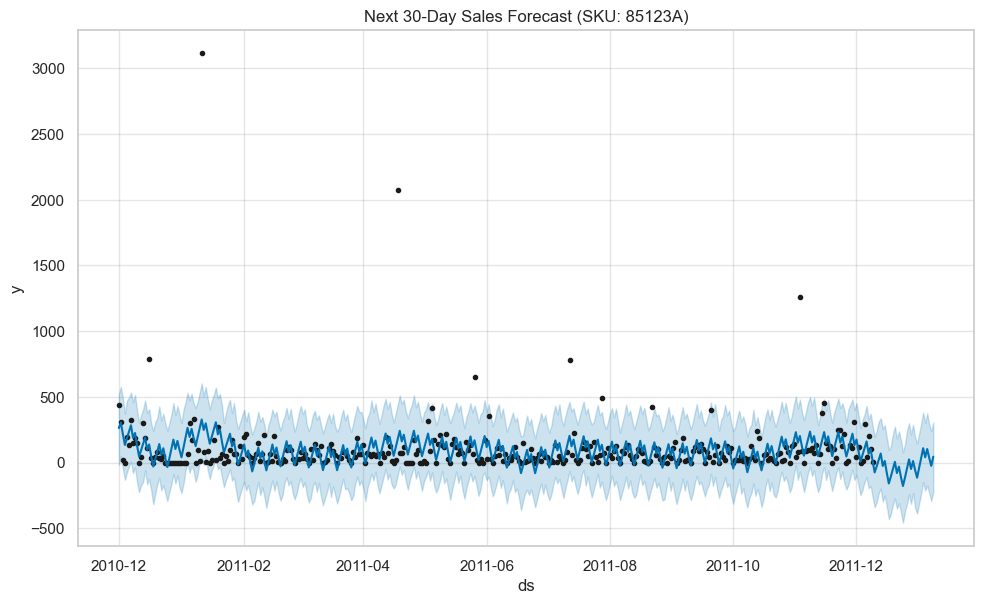

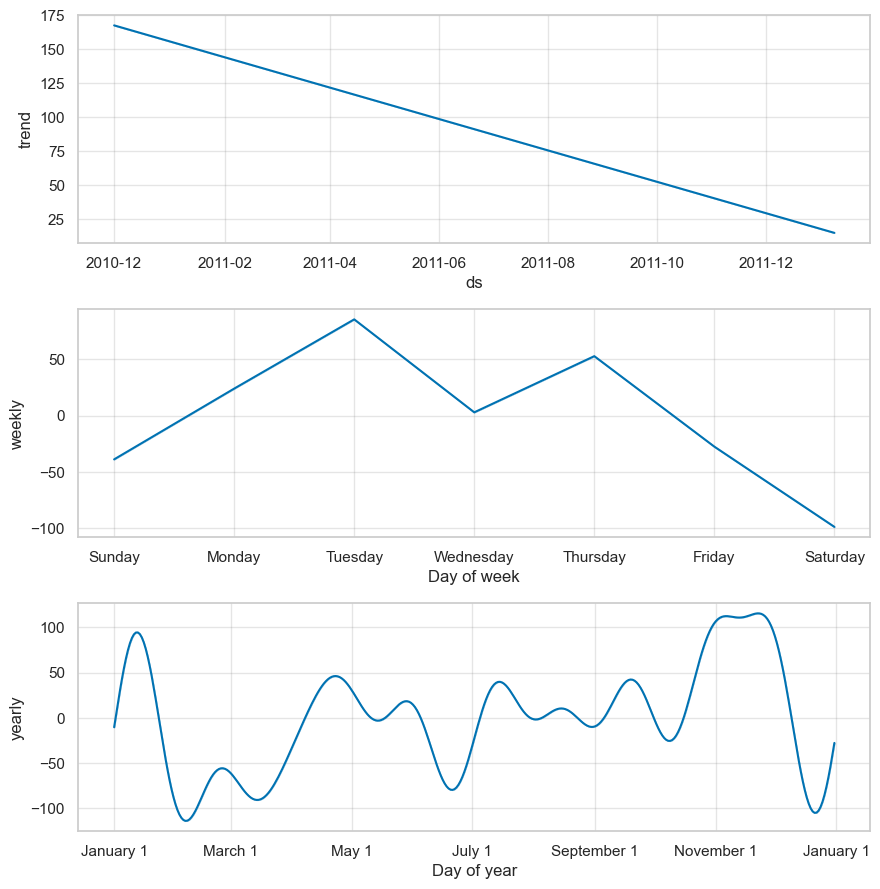

Insight: The component plots clearly show weekly (e.g., high on Fridays) and yearly (peak at year-end) trends.


In [45]:
print("\n--- 4. Generate and Visualize Forecast ---")
# 1. Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30, freq='D')

# 2. Generate the forecast
# The forecast object contains 'yhat' (prediction), 'yhat_lower', 'yhat_upper' (uncertainty)
forecast = model.predict(future)

print("Forecast results (last 5 rows):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 3. Visualize the forecast
fig1 = model.plot(forecast)
plt.title(f'Next 30-Day Sales Forecast (SKU: {SKU_TO_FORECAST})')
plt.show()

# 4. Visualize the time series components
fig2 = model.plot_components(forecast)
plt.show()
print("Insight: The component plots clearly show weekly (e.g., high on Fridays) and yearly (peak at year-end) trends.")

In [46]:
print("\n--- 5. Application: Inventory Optimization (Cost Saving) ---")
print("Objective: Use the forecast to calculate Safety Stock and Reorder Point (ROP)")

# 5.1 Extract forecast data
# We only care about the future 30-day forecast
future_forecast = forecast[forecast['ds'] > sku_prophet['ds'].max()]
avg_daily_demand = future_forecast['yhat'].mean() # Predicted future avg daily demand
demand_std_dev = future_forecast['yhat'].std()   # Predicted demand volatility (std dev)


--- 5. Application: Inventory Optimization (Cost Saving) ---
Objective: Use the forecast to calculate Safety Stock and Reorder Point (ROP)


In [47]:
# 5.2 Define Business Assumptions (CRITICAL!)
# These parameters must be provided by the business. We use assumptions here.
LEAD_TIME_DAYS = 7        # L: Time from placing an order to receiving it (7 days)
SERVICE_LEVEL = 0.95      # Desired service level (95% chance of not stocking out)
Z_SCORE = 1.65            # Z-score corresponding to 95% service level
ORDER_COST = 50           # S: Fixed cost per order (e.g., shipping, admin fees - $50)
HOLDING_COST_PER_UNIT = 1 # H: Annual cost to hold one unit in inventory (e.g., $1)

print(f"\nBusiness Assumptions:")
print(f"  - Lead Time (L): {LEAD_TIME_DAYS} days")
print(f"  - Service Level: {SERVICE_LEVEL * 100}% (Z-score: {Z_SCORE})")
print(f"  - Predicted Avg Daily Demand (d): {avg_daily_demand:.2f} units")
print(f"  - Demand Std Dev (sigma_d): {demand_std_dev:.2f} units")


Business Assumptions:
  - Lead Time (L): 7 days
  - Service Level: 95.0% (Z-score: 1.65)
  - Predicted Avg Daily Demand (d): -28.88 units
  - Demand Std Dev (sigma_d): 72.01 units


In [48]:
# 5.3 Calculate Safety Stock (SS)
# SS = Z * (Std Dev of Demand during Lead Time)
# Std Dev of Demand during Lead Time = sqrt(L * sigma_d^2) = sigma_d * sqrt(L)
safety_stock = Z_SCORE * demand_std_dev * np.sqrt(LEAD_TIME_DAYS)
print(f"\nCalculated Safety Stock (SS): {safety_stock:.2f} units")


Calculated Safety Stock (SS): 314.36 units


In [49]:
# 5.4 Calculate Reorder Point (ROP)
# ROP = (Average demand during lead time) + Safety Stock
reorder_point = (avg_daily_demand * LEAD_TIME_DAYS) + safety_stock
print(f"Calculated Reorder Point (ROP): {reorder_point:.2f} units")

Calculated Reorder Point (ROP): 112.19 units


In [50]:
# 5.5 (Optional) Calculate Economic Order Quantity (EOQ)
# EOQ = sqrt( (2 * D * S) / H )
annual_demand = avg_daily_demand * 365 # D: Total annual demand
eoq = np.sqrt((2 * annual_demand * ORDER_COST) / HOLDING_COST_PER_UNIT)
print(f"Calculated Economic Order Quantity (EOQ): {eoq:.2f} units")

print("\n--- Business Decision Recommendations ---")
print(f"For SKU: {SKU_TO_FORECAST}:")
print(f"1. **When to reorder?** When inventory level drops to **{reorder_point:.0f}** units, trigger a new purchase order.")
print(f"2. **How much to reorder?** To minimize costs, each order should be for **{eoq:.0f}** units.")
print(f"3. **Safety buffer?** Always maintain a safety stock of ~**{safety_stock:.0f}** units to handle 95% of demand volatility.")
print("\nValue: This system shifts inventory management from 'reactive' to 'data-driven,' significantly reducing stockout risk and warehousing costs.")

Calculated Economic Order Quantity (EOQ): nan units

--- Business Decision Recommendations ---
For SKU: 85123A:
1. **When to reorder?** When inventory level drops to **112** units, trigger a new purchase order.
2. **How much to reorder?** To minimize costs, each order should be for **nan** units.
3. **Safety buffer?** Always maintain a safety stock of ~**314** units to handle 95% of demand volatility.

Value: This system shifts inventory management from 'reactive' to 'data-driven,' significantly reducing stockout risk and warehousing costs.
